# Inference on stylized BraTS data

We compare the performance of models trained on stylized datasets on differently stylized datasets.



The dataset comes from http://medicaldecathlon.com/.  
Target: Gliomas segmentation necrotic/active tumour and oedema  
Modality: Multimodal multisite MRI data (FLAIR, T1w, T1gd,T2w)  
Size: 750 4D volumes (484 Training + 266 Testing)  
Source: BRATS 2016 and 2017 datasets.  
Challenge: Complex and heterogeneously-located targets

Data detail found in [BraTS IEEE TMI paper](https://ieeexplore.ieee.org/document/6975210/).


## Setup imports

In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from monai.apps import DecathlonDataset
from monai.data import DataLoader
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AsChannelFirstd,
    AsDiscrete,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    ToTensord,
)
from monai.utils import set_determinism

import torch
from torch.utils.data import random_split

from tqdm import tqdm
import pickle

############################################
# Local imports

SOURCE_CODE_PATH = '/homes/yc7620/Documents/medical-vision-textural-bias/source_code/'
import sys
sys.path.append(SOURCE_CODE_PATH)

from filters_and_operators import (ConvertToMultiChannelBasedOnBratsClassesd,
                                   RandFourierDiskMaskd,
                                   RandPlaneWaves_ellipsoid,
                                   WrapArtifactd)

from utils import show_slice_and_fourier, ReCompose, BratsValIterDataset, model_evaluation
#############################################

# set determinism for reproducibility
set_determinism(seed=0)

root_dir = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/'

device = torch.device("cuda:0")

# root location of all models
models_dir = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/'

# Data loading

In [2]:
from torch.utils.data import IterableDataset

class BratsValIterDataset(IterableDataset):
    """Super iterable dataset where each sample is a BraTS dataset/dataloader with
       different preprocessing pipelines.
       
        Args:
            root_dir (str): path to Brats dataset to be used by the Decathlon class.
            cache_num (int): number of samples to store in cache.
            transforms (dict): Example, 
                {
                'sap10' : saltAndPepper(0.10),
                'sap20' : saltAndPepper(0.20)
                }
            return_loader (bool): set to True to yield dataloders instead of datasets.
    """
    
    def __init__(self, 
                 root_dir: str, 
                 cache_num: int = 0, 
                 transforms: dict=None, 
                 return_loader: bool=False):

        self.root_dir = root_dir
        self.cache_num = cache_num
        self.transforms = transforms
        self.return_loader =return_loader
        self.pipe = Compose(
            [
            LoadImaged(keys=["image", "label"]),
            AsChannelFirstd(keys="image"),
            ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            Spacingd(keys=["image", "label"],
                     pixdim=(1.5, 1.5, 2.0),
                     mode=("bilinear", "nearest"),),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
            NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
            ToTensord(keys=["image", "label"])
        ])
        
    def __iter__(self):
        """Iterate over created datasets/dataloaders"""
        # apply pipeline with appended transform for each iteration step
        for t in self.transforms:

            pipe = ReCompose(self.pipe.transforms)
            pipe.append(self.transforms[t])

            ds = DecathlonDataset(root_dir=self.root_dir, task="Task01_BrainTumour",
                                  transform=pipe, section="validation", download=False,
                                  num_workers=4,cache_num=self.cache_num)

            _ , test_ds = random_split(ds, [48, 48], torch.Generator().manual_seed(0))
            
            if self.return_loader:
                test_loader = DataLoader(test_ds, batch_size=2, shuffle=False, num_workers=4)
                yield (t, test_loader)
            else:
                yield (t, test_ds)

    def __getitem__(self, key:str):
        """Returns item based on key of transforms dictionary"""
        
        pipe = ReCompose(self.pipe.transforms)
        pipe.append(self.transforms[key])
        
        ds = DecathlonDataset(root_dir=self.root_dir, task="Task01_BrainTumour",
                                  transform=pipe, section="validation", download=False,
                                  num_workers=4,cache_num=self.cache_num)
        _ , test_ds = random_split(ds, [48, 48], torch.Generator().manual_seed(0))
            
        if self.return_loader:
            test_loader = DataLoader(test_ds, batch_size=2, shuffle=False, num_workers=4)
            return test_loader
        else:
            return test_ds

# Data example

In [117]:
ds = BratsValIterDataset(root_dir, transforms={'baseline':None}, return_loader=False)

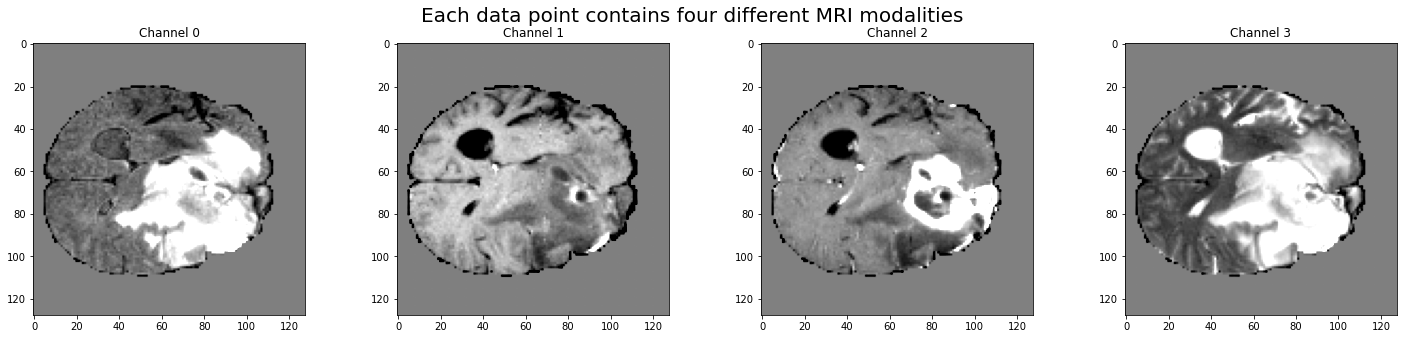

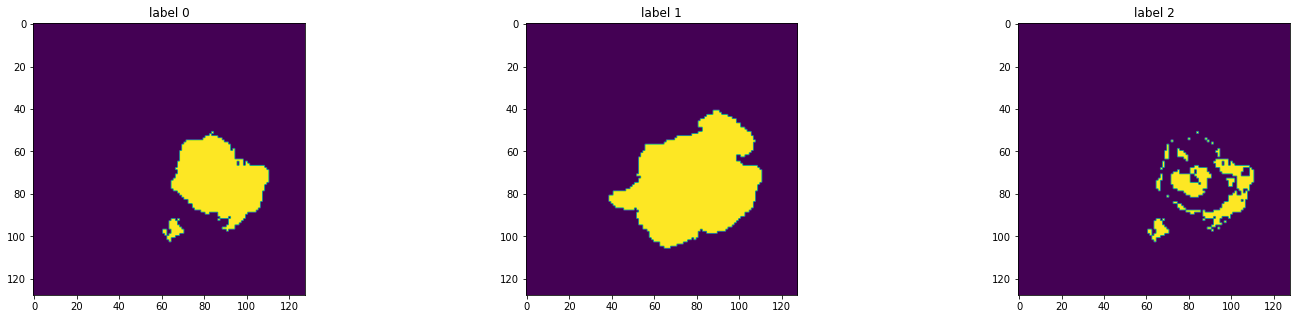

In [118]:
img = ds["baseline"][3]["image"] 
seg = ds["baseline"][3]["label"]

plt.figure(figsize=(25,5))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(img[i,:,:,32], cmap='gray', vmin=-1.5, vmax=1.5)
    plt.title(f"Channel {i}")
plt.suptitle("Each data point contains four different MRI modalities", size = 20)
plt.show()
plt.figure(figsize=(25,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(seg[i,:,:,32])
    plt.title(f"label {i}")
plt.show()

# Gibbs artifacts

Create dataloader for each Gibbs stylization

In [3]:
gibbs_transforms = {'baseline':None,
                    'gibbs25': RandFourierDiskMaskd(keys='image', r=25 , inside_off=False, prob=1.),
                    'gibbs20': RandFourierDiskMaskd(keys='image', r=20 , inside_off=False, prob=1.),
                    'gibbs15': RandFourierDiskMaskd(keys='image', r=15 , inside_off=False, prob=1.),
                    'gibbs12.5': RandFourierDiskMaskd(keys='image', r=12.5 , inside_off=False, prob=1.),
                    'gibbs10': RandFourierDiskMaskd(keys='image', r=10 , inside_off=False, prob=1.),
                    'gibbs9': RandFourierDiskMaskd(keys='image', r=9 , inside_off=False, prob=1.)}


gibbs_dataloaders = BratsValIterDataset(root_dir, 50, gibbs_transforms, True)

Visualize example of each stylized dataset

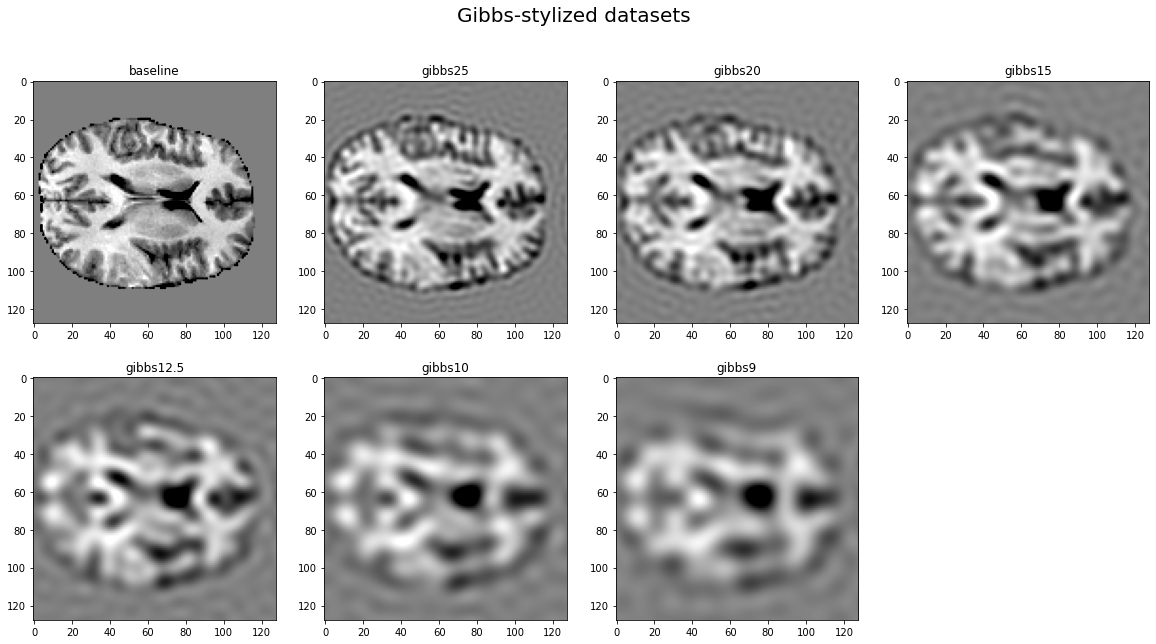

In [4]:
# create super dataset of Gibbs datasets
gibbs_dsets = BratsValIterDataset(root_dir, transforms=gibbs_transforms, return_loader=False)
# show channel of first image in each dataset
plt.figure(figsize=(20,10))
for i, (name,ds) in enumerate(gibbs_dsets):
    plt.subplot(2,4,i+1)
    plt.imshow(ds[0]['image'][1,:,:,32], cmap='gray', vmin=-1.5,vmax=1.5)
    plt.title(name)
plt.suptitle('Gibbs-stylized datasets', size = 20)
plt.show()

Import the Gibbs-stylized models.

In [24]:
# baseline model
path = os.path.join(models_dir, 'baseline_model/best_metric_model_baseline.pth')
baseline = model_evaluation(path, 'baseline_model')

# gibbs models
path = os.path.join(models_dir, 'stylized_Gibbs25/best_metric_model_Gibbs25.pth')
gibbs25 = model_evaluation(path, 'Gibbs25_model')

path = os.path.join(models_dir, 'stylized_Gibbs20/best_metric_model_Gibbs20.pth')
gibbs20 = model_evaluation(path, 'Gibbs20_model')

path = os.path.join(models_dir, 'stylized_Gibbs15/best_metric_model_Gibbs15.pth')
gibbs15 = model_evaluation(path, 'Gibbs15_model')

path = os.path.join(models_dir, 'stylized_Gibbs12.5/best_metric_model_Gibbs12.5.pth')
gibbs12p5 = model_evaluation(path, 'Gibbs12.5_model')

path = os.path.join(models_dir, 'stylized_Gibbs10/best_metric_model_Gibbs10.pth')
gibbs10 = model_evaluation(path, 'Gibbs10_model')

path = os.path.join(models_dir, 'stylized_Gibbs9/best_metric_model_Gibbs9.pth')
gibbs9 = model_evaluation(path, 'Gibbs9_model')

Test each stylized model on each stylized dataset.

In [ ]:
gibbs_list = [gibbs25, gibbs20, gibbs15, gibbs12p5, gibbs10, gibbs9]
baseline_list = [baseline]

for name, dl in gibbs_dataloaders:
    for model in gibbs_list:
        model.add_eval(name, dl)
        
for name, dl in gibbs_dataloaders:
    baseline.add_eval(name, dl)

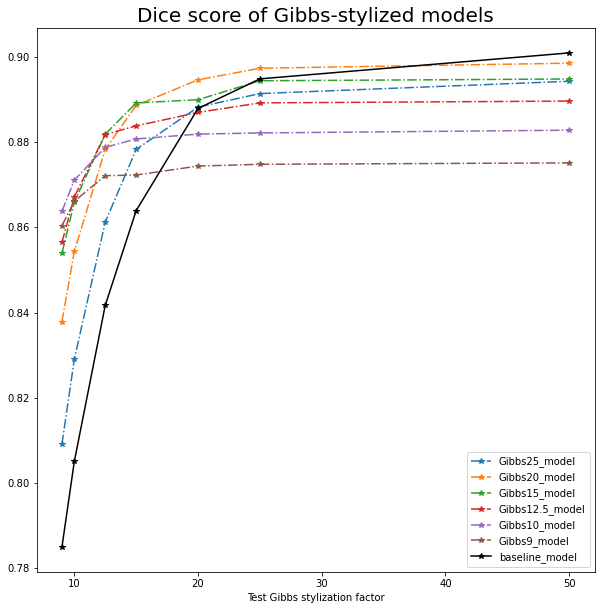

In [26]:
from plotting import plot_performance_on_wraparound

plt.figure(figsize=(10,10))
plot_performance_on_wraparound([9, 10,12.5,15,20,25,50],gibbs_list,'wt', mark = '-.*')
plot_performance_on_wraparound([9, 10,12.5,15,20,25,50],baseline_list,'wt', mark = '-*', c='k')
plt.xlabel('Test Gibbs stylization factor')
plt.title('Dice score of Gibbs-stylized models', size=20)
plt.show()

# Spikes artifacts

Create dataloader for each Spikes stylization

In [121]:
spikes_transforms = {
    'baseline':None, 
    'spikes12': RandPlaneWaves_ellipsoid('image',55.,55.,30., intensity_value=12, prob=1.),
    'spikes14': RandPlaneWaves_ellipsoid('image',55.,55.,30., intensity_value=14, prob=1.),
    'spikes15': RandPlaneWaves_ellipsoid('image',55.,55.,30., intensity_value=15, prob=1.),
    'spikes16': RandPlaneWaves_ellipsoid('image',55.,55.,30., intensity_value=16, prob=1.),
    'spikes16.5': RandPlaneWaves_ellipsoid('image',55.,55.,30., intensity_value=16.5, prob=1.),
    'spikes17': RandPlaneWaves_ellipsoid('image',55.,55.,30., intensity_value=17, prob=1.),
}

spikes_dataloaders = BratsValIterDataset(root_dir, 50, spikes_transforms, True)

Visualize example of each stylized dataset:

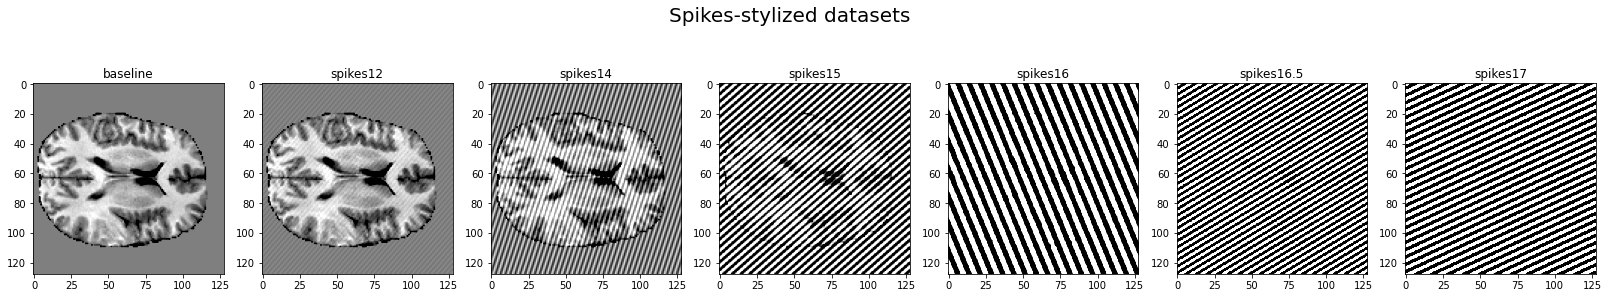

In [122]:
# create super dataset of Spikes datasets
spikes_dsets = BratsValIterDataset(root_dir, transforms=spikes_transforms, return_loader=False)
# show channel of first image in each dataset
plt.figure(figsize=(28,5))
for i, (name,ds) in enumerate(spikes_dsets):
    plt.subplot(1,7,i+1)
    plt.imshow(ds[0]['image'][1,:,:,32], cmap='gray', vmin=-1.5, vmax=1.5)
    plt.title(name)
plt.suptitle('Spikes-stylized datasets', size = 20)
plt.show()

Import the spikes-stylized models.

In [33]:
# baseline model
path = os.path.join(models_dir, 'baseline_model/best_metric_model_baseline.pth')
baseline = model_evaluation(path, 'baseline_model')

# spikes models
path = os.path.join(models_dir, 'stylized_planes12/best_metric_model_planes_a55.0b55.0c30.0_int12.0.pth')
spikes12 = model_evaluation(path, 'Planes12_model')

path = os.path.join(models_dir, 'stylized_planes13/best_metric_model_planes_a55.0b55.0c30.0_int13.0.pth')
spikes13 = model_evaluation(path, 'Planes13_model')

path = os.path.join(models_dir, 'stylized_planes14/best_metric_model_planes_a55.0b55.0c30.0_int14.0.pth')
spikes14 = model_evaluation(path, 'Planes14_model')

path = os.path.join(models_dir, 'stylized_planes15/best_metric_model_planes_a55.0b55.0c30.0_int15.0.pth')
spikes15 = model_evaluation(path, 'Planes15_model')

path = os.path.join(models_dir, 'stylized_planes16/best_metric_model_planes_a55.0b55.0c30.0_int16.0.pth')
spikes16 = model_evaluation(path, 'Planes16_model')

path = os.path.join(models_dir, 'stylized_planes17/best_metric_model_planes_a55.0b55.0c30.0_int17.0.pth')
spikes17 = model_evaluation(path, 'Planes17_model')

Test each stylized model on each stylized dataset.

In [ ]:
spikes_list = [spikes12, spikes13, spikes14, spikes15, spikes16, spikes17]
baseline_list = [baseline]

for name, dl in spikes_dataloaders:
    for model in spikes_list:
        model.add_eval(name, dl)
        
for name, dl in spikes_dataloaders:
    baseline.add_eval(name, dl)

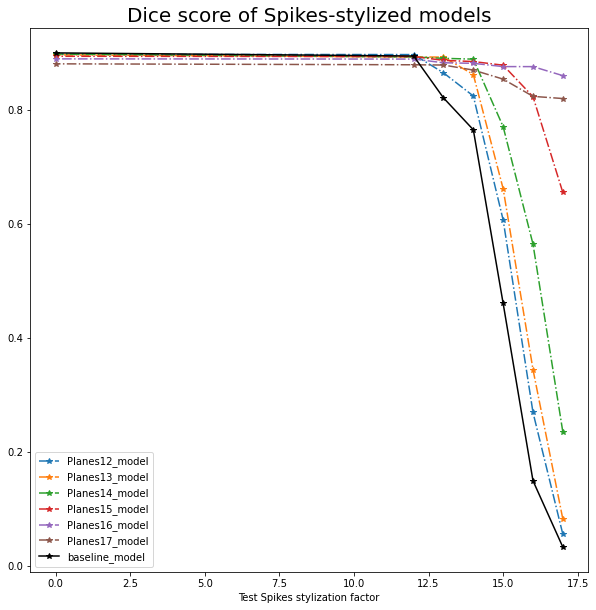

In [40]:
plt.figure(figsize=(10,10))
plot_performance_on_wraparound([17, 16, 15, 14, 13, 12, 0], spikes_list,'wt', mark = '-.*')
plot_performance_on_wraparound([17, 16, 15, 14, 13, 12, 0], baseline_list,'wt', mark = '-*', c='k')
plt.xlabel('Test Spikes stylization factor')
plt.title('Dice score of Spikes-stylized models', size=20)
plt.show()

# Wraparound artifacts

Create dataloaders for each wraparound artifact intensity

In [123]:
wrap_transforms = { 
                  'wrap0': WrapArtifactd("image", 0.0),
                  'wrap0p125': WrapArtifactd("image", 0.125), 
                  'wrap0p25': WrapArtifactd("image", 0.25),
                  'wrap0p5': WrapArtifactd("image", 0.5),
                  'wrap0p75': WrapArtifactd("image", 0.75),
                  'baseline': None
}

wrap_dataloaders = BratsValIterDataset(root_dir, 50, wrap_transforms, True)

Visualize example of each stylized dataset:

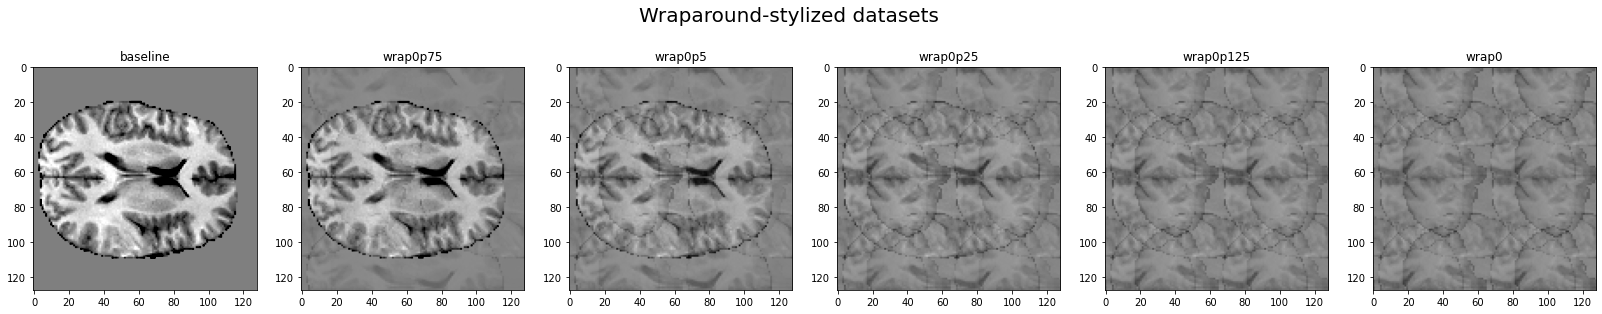

In [124]:
# create super dataset of wraparound datasets
wrap_dsets = BratsValIterDataset(root_dir, transforms=wrap_transforms, return_loader=False)
# show channel of first image in each dataset
plt.figure(figsize=(28,5))
for i, (name,ds) in enumerate(wrap_dsets):
    plt.subplot(1,6,6-i)
    plt.imshow(ds[0]['image'][1,:,:,32], cmap='gray', vmin=-1.5, vmax=1.5)
    plt.title(name)
plt.suptitle('Wraparound-stylized datasets', size = 20)
plt.show()

Import the wraparound-stylized models.

In [6]:
# baseline model
path = os.path.join(models_dir, 'baseline_model/best_metric_model_baseline.pth')
baseline = model_evaluation(path, 'baseline_model')

# wraparound models
path = os.path.join(models_dir, 'stylized_model_wrap0.0/stylized_model_wrap0.0.pth')
wrap0 = model_evaluation(path, 'wrap0_model')

path = os.path.join(models_dir, 'stylized_model_wrap0.25/stylized_model_wrap0.25.pth')
wrap0p25 = model_evaluation(path, 'wrap0.25_model')

path = os.path.join(models_dir, 'stylized_model_wrap0.5/stylized_model_wrap0.5.pth')
wrap0p5 = model_evaluation(path, 'wrap0.5_model')

path = os.path.join(models_dir, 'stylized_model_wrap0.75/stylized_model_wrap0.75.pth')
wrap0p75 = model_evaluation(path, 'wrap0.75_model')

Test each stylized model on each stylized dataset.

In [ ]:
baseline_list = [baseline]

wrap_list = [baseline, wrap0, wrap0p25, wrap0p5, wrap0p75]

for name, dl in wrap_dataloaders:
    for model in wrap_list:
        model.add_eval(name, dl)

Text(0.5, 1.0, 'Dice score of wraparound-stylized models')

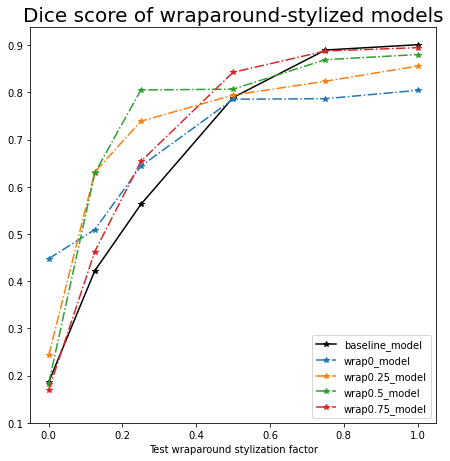

In [19]:
from plotting import plot_performance_on_wraparound

plt.figure(figsize=(16,16))
plot_performance_on_wraparound([0, 0.125, .25, .5, .75, 1.],baseline_list,'wt', mark = '-*', c='k' )
plot_performance_on_wraparound([0, 0.125, .25, .5, .75, 1.],wrap_list,'wt', mark = '-.*')
plt.yticks(np.arange(.1,1.,.1))
plt.xlabel('Test wraparound stylization factor')
plt.title('Dice score of wraparound-stylized models', size=20)